## 패키지 import

In [8]:
%matplotlib inline

import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

## patient ID info.

In [9]:
# Some constants 
INPUT_FOLDER = '/home/miruware/Downloads/20patients_dicom'
patients = list(map(int,os.listdir(INPUT_FOLDER)))
patients.sort()
print(patients)
print(len(patients))

[1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23]
20


## patient ID 1

In [10]:
data_path = "/home/miruware/Downloads/20patients_dicom/1/"
output_path = working_path = "/home/miruware/Documents/"
g = glob(data_path + '/*.dcm')

# Print out the first 5 file names to verify we're in the right folder.
print ("Total of %d DICOM images.\nFirst 5 filenames:" % len(g))
print ('\n'.join(g[:5]))

Total of 108 DICOM images.
First 5 filenames:
/home/miruware/Downloads/20patients_dicom/1/BII-LUAD-0010264.dcm
/home/miruware/Downloads/20patients_dicom/1/BII-LUAD-0010272.dcm
/home/miruware/Downloads/20patients_dicom/1/BII-LUAD-0010186.dcm
/home/miruware/Downloads/20patients_dicom/1/BII-LUAD-0010259.dcm
/home/miruware/Downloads/20patients_dicom/1/BII-LUAD-0010195.dcm


## load_scan : will find the pixel size in the Z direction
ImagePositionPatient : Image Position (0020,0032) specifies the x, y, and z coordinates of the upper left hand corner of the image
SliceLocation : Slice Location (0020,1041) is defined as the relative position of the image plane expressed in mm

In [11]:
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber)) #DICOM 의 메타데이터 -> slices 총 108개 
    print(len(slices))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2]) #z 좌표 
        print(slices[0].ImagePositionPatient[2])
        print(slices[1].ImagePositionPatient[2])
        print(slice_thickness,end=' used ImagePosition\n')
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        print(slice_thickness,end=' used SliceLocation\n')
    for s in slices:
        s.SliceThickness = slice_thickness

    return slices

In [12]:
patient=load_scan(data_path) #patient 내에 SliceThickness 속성이 추가된 108개의 Dicom 데이터가 있음 

108
1065
1062
3.0 used ImagePosition


In [13]:
for slice in patient:
    print(slice.SliceThickness)
    break

3.0


## get_pixels_hu
The pixels that fall outside of these bounds get the fixed value -2000. The first step is setting these values to 0, which currently corresponds to air. 

In [14]:
def get_pixels_hu(scans): 
    image = np.stack([s.pixel_array for s in scans])
    print(image)
    print(image.shape)
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    print(intercept)
    slope = scans[0].RescaleSlope
    print(slope)
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    print(image.shape)
    print(image)
    
    return np.array(image, dtype=np.int16)

In [41]:
id=1
imgs = get_pixels_hu(patient)

[[[ 0  5 18 ... 24 23 23]
  [11 20 28 ... 30 22 13]
  [23 32 36 ... 20 20 20]
  ...
  [15 22 26 ... 22 24 26]
  [ 6 17 27 ... 21 26 25]
  [ 0  7 21 ... 16 27 27]]

 [[ 0  5 19 ... 16 15 25]
  [ 8 23 34 ... 17 16 25]
  [22 33 39 ... 21 19 27]
  ...
  [23 26 24 ... 18 18 17]
  [ 3 18 29 ... 20 19 17]
  [ 0 12 24 ... 21 18 12]]

 [[ 0  7 25 ... 15 20 28]
  [ 5 12 24 ... 14 21 31]
  [21 23 26 ... 15 20 28]
  ...
  [23 28 30 ... 20 18 18]
  [ 3 17 29 ... 23 22 17]
  [ 0 11 25 ... 21 20 13]]

 ...

 [[ 0  6 18 ... 43 32 20]
  [ 9 17 21 ... 34 26 20]
  [23 28 26 ... 24 23 25]
  ...
  [ 6 14 22 ... 20 16 17]
  [ 2  9 16 ... 16 15 14]
  [ 0  5 10 ... 20 24 24]]

 [[ 0  4 15 ... 46 34 17]
  [12 17 18 ... 36 24 12]
  [29 28 21 ... 25 20 18]
  ...
  [11 18 24 ... 28 21 17]
  [ 3 10 16 ... 29 24 18]
  [ 0  3 10 ... 30 28 22]]

 [[ 0  0  6 ... 24 31 34]
  [ 5  4  6 ... 23 25 26]
  [17 15  8 ... 22 22 20]
  ...
  [ 3 12 14 ... 37 34 15]
  [ 0  4  8 ... 34 34 25]
  [ 0  0  8 ... 20 24 40]]]
(108, 512,

In [42]:
np.save(output_path + "fullimages_%d.npy" % (id), imgs)

## Displaying Images

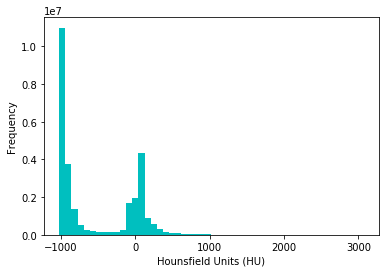

In [15]:
file_used=output_path+"fullimages_%d.npy" % id
imgs_to_process = np.load(file_used).astype(np.float64) 

plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

## Displaying an Image Stack

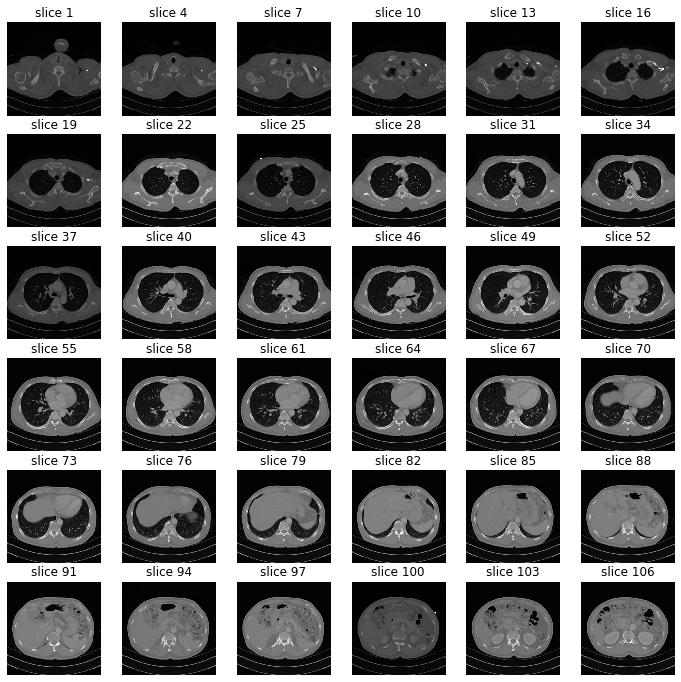

In [16]:
id = 1
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

def sample_stack(stack, rows=6, cols=6, start_with=1, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process)

## resampling
In order to display the CT in 3D isometric form (which we will do below), and also to compare between different scans, it would be useful to ensure that each slice is resampled in 1x1x1 mm pixels and slices.

### scipy.ndimage.interpolation.zoom


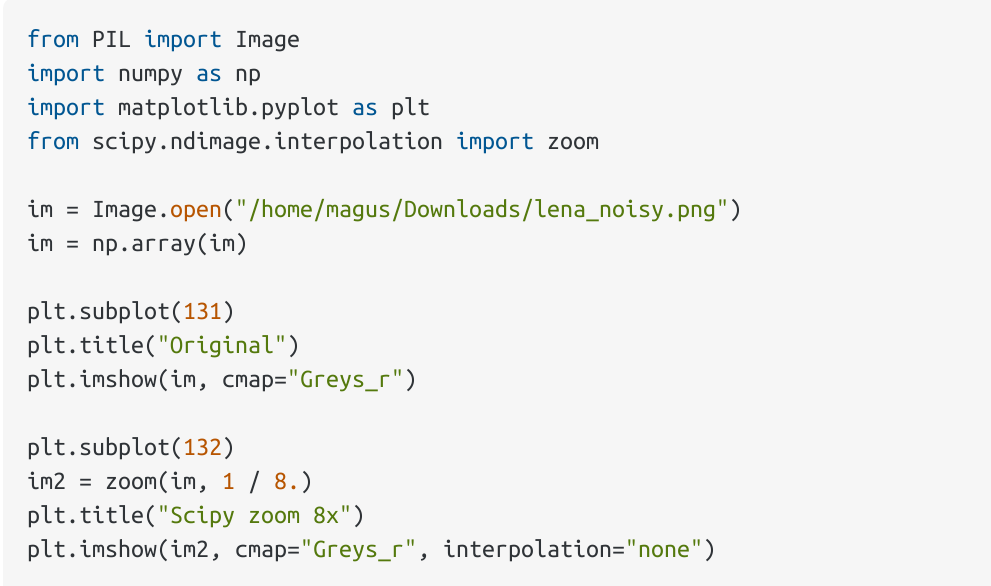

In [5]:
from IPython.display import Image
Image('/home/miruware/Pictures/선택 영역_055.png')

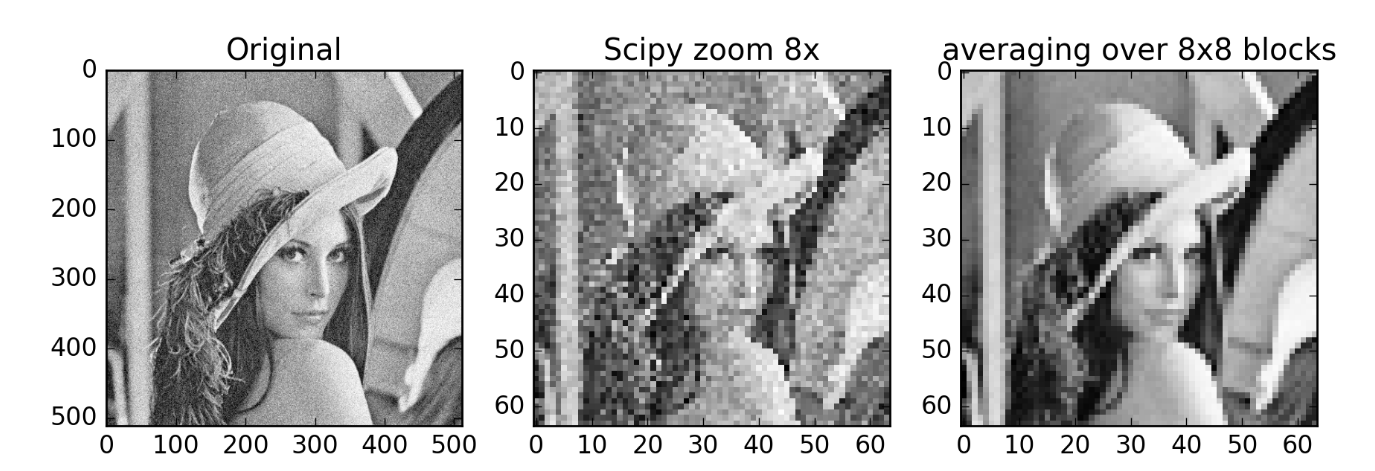

In [6]:
Image('/home/miruware/Pictures/선택 영역_054.png')

In [20]:
id = 1
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    print(scan[0].PixelSpacing,end=' pixelspacing\n') #physical distance in the patient between the center of each pixel
    spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))
    print(spacing,end=' spacing\n')

    resize_factor = spacing / new_spacing
    print(resize_factor,end=' resize_factor\n')
    new_real_shape = image.shape * resize_factor
    print(image.shape,end=' image.shape\n') # 원 shape 
    print(new_real_shape,end=' new_real_shape\n') # 바뀌어야하는 shape 
    new_shape = np.round(new_real_shape)
    print(new_shape,end=' new_shape\n') # 반올림 
    real_resize_factor = new_shape / image.shape
    print(real_resize_factor,end=' real_resize_factor\n')
    new_spacing = spacing / real_resize_factor
    print(new_spacing,end=' new_spacing\n') #바뀌어야하는 pixel spacing,slicethickness
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

print("Shape before resampling\t", imgs_to_process.shape)
imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])
print("Shape after resampling\t", imgs_after_resamp.shape)


Shape before resampling	 (108, 512, 512)
[0.681640625, 0.681640625] pixelspacing
[3.         0.68164062 0.68164062] spacing
[3.         0.68164062 0.68164062] resize_factor
(108, 512, 512) image.shape
[324. 349. 349.] new_real_shape
[324. 349. 349.] new_shape
[3.         0.68164062 0.68164062] real_resize_factor
[1. 1. 1.] new_spacing
Shape after resampling	 (324, 349, 349)


## Normalization
현재 HU 값 범위는 -1000 ~ 3000
-1000 ~ 는 공기를 나타내고, 400 ~ 는 뼈를 나타내므로 관심 영역이 아님. 

In [21]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

In [22]:
normalize(imgs_after_resamp)

array([[[0.        , 0.        , 0.        , ..., 0.00071429,
         0.        , 0.        ],
        [0.        , 0.00571429, 0.00285714, ..., 0.00285714,
         0.        , 0.        ],
        [0.        , 0.00642857, 0.00571429, ..., 0.        ,
         0.        , 0.00285714],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.00214286],
        [0.        , 0.00071429, 0.00214286, ..., 0.        ,
         0.00071429, 0.00071429],
        [0.        , 0.        , 0.00071429, ..., 0.        ,
         0.        , 0.00214286]],

       [[0.        , 0.        , 0.        , ..., 0.00071429,
         0.        , 0.        ],
        [0.        , 0.00714286, 0.00357143, ..., 0.00285714,
         0.        , 0.        ],
        [0.        , 0.00571429, 0.00571429, ..., 0.        ,
         0.        , 0.00357143],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 